# 1) Exploración de datos

In [1]:
import pandas as pd

df = pd.read_csv('train_set.csv')

df.head()

<ipython-input-1-8b11550b50ce>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_set.csv')


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB
None


- Hay 700,000 registros.
- En varias columnas hay datos faltantes. Pero no representan una proporción considerablemente alta. mas del 10% podria considerarse alto, entonces la variable podría no ser confiable. Pero depende del contexto.
- Hay varias columnas con datos tipo object, para algunas se puede cambiar, como para start_time y end_time. Mientras que también existen variables categóricas como passholder_type y trip_route_category.
- Es necesario revisar a profundidad la calidad de los datos.

In [3]:
df.isna().sum()

,0
trip_id,0
duration,0
start_time,0
end_time,0
start_lat,5563
start_lon,5563
end_lat,18574
end_lon,18574
bike_id,0
plan_duration,208


Considero que hay pocas filas con valores null, las filas con más valores faltantes son las de end_lat y end_lon, con exactamente el 2.65% de valores faltantes. Por lo que la eliminacion de esas filas puede ser una opción razonable. Teorícamente esto no debería afectar el rendimiento del modelo. Normalmente en esta etapa me tomo más tiempo para poder decidir qué hacer, pero mi tiempo es limitado para este análisis. Así, que, haciendo la suposición de que la localización geográfica puede tener un impacto relevante, la imputación de los valores faltantes también puede ser una opción viable ante la falta de tiempo para ofrecer una solución más elavorada a la falta de datos. Los datos faltantes serán tratados como sigue:

- passholder_type --> moda

- start_lat --> media

- start_lon --> media

- end_lat --> media

- end_lon --> media

- plan_duratioin --> mediana


In [4]:
df['passholder_type'] = df['passholder_type'].fillna(df['passholder_type'].mode()[0])
df['start_lat'] = df['start_lat'].fillna(df['start_lat'].mean())
df['start_lon'] = df['start_lon'].fillna(df['start_lon'].mean())
df['end_lat'] = df['end_lat'].fillna(df['end_lat'].mean())
df['end_lon'] = df['end_lon'].fillna(df['end_lon'].mean())
df['plan_duration'] = df['plan_duration'].fillna(df['plan_duration'].median())

Ahora hay que comprobar que efectivamente no hay valores faltantes:

In [5]:
df.isna().sum()

,0
trip_id,0
duration,0
start_time,0
end_time,0
start_lat,0
start_lon,0
end_lat,0
end_lon,0
bike_id,0
plan_duration,0


Respecto a la variable de "duration" y "plan_duration", voy a pasarlas de minutos a horas. Esto hace más consistes los registros y también más fáciles de interpretar. Además, puede facilitar la interpretación del modelo y su entrenamiento debido a que la magnitud de los valores son más chicos.

In [6]:
df['duration'] = df['duration'] / 60
df['plan_duration'] = df['plan_duration'] / 60

Ahora hay que verificar la conversión.

In [7]:
df[['duration', 'plan_duration']].head()

,duration,plan_duration
0,0.583333,0.016667
1,0.533333,0.000000
2,0.100000,0.500000
3,2.300000,0.016667
4,0.233333,0.500000


La conversión se efectuó correctamente, pero existe un valor de 0.000 en plan_duration, siendo que la duración del viaje fue de 0.5333 horas. Esto denota inconsistencia, quizá fue un error en el registro. Si tuviera más tiempo, revisaría el origen de los datos, y en este caso preguntaría a la empresa que nos proporcionó los datos qué significa esto. Para poder hacer el debido tratamiento. Al verme imposibilidato, solo puedo hacer conjeturas y experimentación.
voy a inspeccionar más de cerca esto. Quiero ver cuántos valores de cero hay en esta columna.

In [8]:
zero_values = df[df['plan_duration'] == 0].shape[0]
print(f'Cantidad de valores cero en plan_duration: {zero_values}')


Cantidad de valores cero en plan_duration: 63275


¡Es una cantidad alta de valores 0.0!

Esa cantidad corresponde al 9.04%. Podría ser un problema. Voy a revisar las filas que corresponden a valores 0.0 en plan_duration

In [9]:

df[df['plan_duration'] == 0].sample(5)


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
680877,76351333,0.500000,2018-03-11 19:27:00,2018-03-11 19:57:00,33.995560,-118.481552,33.988419,-118.451630,06643,0.0,One Way,Walk-up,4214,4204
502843,20006818,0.233333,2/14/2017 14:31,2/14/2017 14:45,34.051941,-118.243530,34.050140,-118.233238,6641,0.0,One Way,Walk-up,3030,3079
697454,92498721,0.266667,2018-06-17 01:39:00,2018-06-17 01:55:00,34.045422,-118.253517,34.028511,-118.256668,05837,0.0,One Way,Walk-up,3051,3045
51670,80740485,0.316667,2018-04-07 14:59:00,2018-04-07 15:18:00,34.049980,-118.247162,34.063389,-118.236160,06330,0.0,One Way,Walk-up,3027,3066
81427,91372461,0.150000,2018-06-10 11:08:00,2018-06-10 11:17:00,34.138210,-118.147079,34.135250,-118.132370,06362,0.0,One Way,Walk-up,4149,4158


Parece que los valores de 0.0 en plan_duration corresponden a Walk-Up en passholder_type, vamos a verificarlo:

In [10]:
zero_duration_rows = df[df['plan_duration'] == 0.0]

walk_up_check = zero_duration_rows['passholder_type'] == 'Walk-up'

print(f"Total de valores 0.0 en 'plan_duration': {len(zero_duration_rows)}")
print(f"Total de valores 'Walk-up' en 'passholder_type' para esos valores 0.0: {walk_up_check.sum()}")
print(f"Porcentaje de valores 'Walk-up' en esos casos: {walk_up_check.mean() * 100:.2f}%")

Total de valores 0.0 en 'plan_duration': 63275
Total de valores 'Walk-up' en 'passholder_type' para esos valores 0.0: 63275
Porcentaje de valores 'Walk-up' en esos casos: 100.00%


En conclusión: Los valores de plan_duration = 0.0, indican que el usuario no tiene un plan de suscripción y está utilizando un pase de un solo viaje.

Definitivamente los datos siempre merecen una revisión mas exhaustiva, pero no tengo tanto tiempo disponible para poder hacerlo como me gustaría. empezar a hacer gráficos con los datos en este estado puede ser prematuro, pero dadas las condiciones de tiempo, no tengo otra opción.

In [11]:
df.describe()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station
count,7.000000e+05,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,1.069468e+08,0.618083,34.044952,-118.253849,34.044175,-118.259183,0.748738,3499.720464,3489.726771
std,4.497342e+07,2.088375,0.323960,2.323352,0.295717,2.101335,1.546714,615.918795,613.040769
min,8.369648e+06,0.016667,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000
25%,7.538051e+07,0.116667,34.037460,-118.280952,34.038609,-118.279762,0.016667,3031.000000,3030.000000
50%,1.179410e+08,0.216667,34.046612,-118.256668,34.046520,-118.256981,0.500000,3064.000000,3064.000000
75%,1.404178e+08,0.433333,34.051941,-118.247162,34.050911,-118.247162,0.500000,4214.000000,4214.000000
max,1.794831e+08,24.000000,55.705528,118.238258,55.705528,37.606541,16.650000,4594.000000,4594.000000


Con esta descripción estadística me doy cuenta de que me faltan algunas columnas, entre las que están start_time y end_time. En realidad estas contienen mucha información, así que voy a ponerlas en un formato que me sea más útil, como datetime de pandas ya que en este formato pod´riamos extraeer características útiles como día de la semana, hora del día, mes y por extensión la estación del año, por ejemplo. Así que procederé a hacerlo.

In [12]:
df['start_time']

,start_time
0,2018-08-07 11:20:00
1,9/17/2017 17:51
2,2019-04-22 09:22:00
3,9/22/2019 11:27
4,1/31/2020 17:11
...,...
699995,2018-04-25 18:32:00
699996,2019-11-12 16:49:10
699997,2018-01-13 15:49:00
699998,2019-02-04 14:16:00


algunos registros tienen segundos y otros no, ademas algunos estan separados por /  y otros por -. Por lo que hay que poner cada registro en un solo formato, es decir, normalizarlos.

In [13]:
# Reemplazar '-' por '/' solo en las columnas de fecha
df['start_time'] = df['start_time'].str.replace('-', '/', regex=False)
df['end_time'] = df['end_time'].str.replace('-', '/', regex=False)

In [14]:
df[['start_time', 'end_time']]

,start_time,end_time
0,2018/08/07 11:20:00,2018/08/07 11:55:00
1,9/17/2017 17:51,9/17/2017 18:23
2,2019/04/22 09:22:00,2019/04/22 09:28:00
3,9/22/2019 11:27,9/22/2019 13:45
4,1/31/2020 17:11,1/31/2020 17:25
...,...,...
699995,2018/04/25 18:32:00,2018/04/25 18:49:00
699996,2019/11/12 16:49:10,2019/11/12 16:58:51
699997,2018/01/13 15:49:00,2018/01/13 15:55:00
699998,2019/02/04 14:16:00,2019/02/04 14:19:00


Añadir formato con segundos a los registros faltantes.

In [15]:

import re

def has_seconds(time_str):
    pattern = r'\d{2}:\d{2}:\d{2}'
    return bool(re.search(pattern, time_str))

df['has_seconds_start'] = df['start_time'].astype(str).apply(has_seconds)

df['has_seconds_end'] = df['end_time'].astype(str).apply(has_seconds)

df_without_seconds_start = df[~df['has_seconds_start']]

df_without_seconds_end = df[~df['has_seconds_end']]

print("Registros de start_time sin segundos:")
print(df_without_seconds_start[['start_time', 'has_seconds_start']].head())

print("\nRegistros de end_time sin segundos:")
print(df_without_seconds_end[['end_time', 'has_seconds_end']].head())

df.loc[~df['has_seconds_start'], 'start_time'] = df.loc[~df['has_seconds_start'], 'start_time'] + ':00'

df.loc[~df['has_seconds_end'], 'end_time'] = df.loc[~df['has_seconds_end'], 'end_time'] + ':00'

print("\nDataFrame actualizado:")
print(df[['start_time', 'has_seconds_start', 'end_time', 'has_seconds_end']].head())


Registros de start_time sin segundos:
         start_time  has_seconds_start
1   9/17/2017 17:51              False
3   9/22/2019 11:27              False
4   1/31/2020 17:11              False
10  8/31/2017 23:22              False
12  1/30/2020 11:55              False

Registros de end_time sin segundos:
           end_time  has_seconds_end
1   9/17/2017 18:23            False
3   9/22/2019 13:45            False
4   1/31/2020 17:25            False
10  8/31/2017 23:46            False
12  1/30/2020 13:08            False

DataFrame actualizado:
            start_time  has_seconds_start             end_time  \
0  2018/08/07 11:20:00               True  2018/08/07 11:55:00   
1   9/17/2017 17:51:00              False   9/17/2017 18:23:00   
2  2019/04/22 09:22:00               True  2019/04/22 09:28:00   
3   9/22/2019 11:27:00              False   9/22/2019 13:45:00   
4   1/31/2020 17:11:00              False   1/31/2020 17:25:00   

   has_seconds_end  
0             True  
1     

Vamos a verificar que la estructura del tiempo sea consistente para ambas columnas:

In [16]:
df[['start_time','end_time']]

,start_time,end_time
0,2018/08/07 11:20:00,2018/08/07 11:55:00
1,9/17/2017 17:51:00,9/17/2017 18:23:00
2,2019/04/22 09:22:00,2019/04/22 09:28:00
3,9/22/2019 11:27:00,9/22/2019 13:45:00
4,1/31/2020 17:11:00,1/31/2020 17:25:00
...,...,...
699995,2018/04/25 18:32:00,2018/04/25 18:49:00
699996,2019/11/12 16:49:10,2019/11/12 16:58:51
699997,2018/01/13 15:49:00,2018/01/13 15:55:00
699998,2019/02/04 14:16:00,2019/02/04 14:19:00


Hay otra inconsistencia: algunos registros comienzan por año y otros no. Se debe normalizar eso.

In [17]:
def ajustar_fecha(fecha):
    partes = fecha.split(' ')

    fecha_parts = partes[0].split('/')

    if len(fecha_parts[0]) == 4:
        return fecha
    else:
        fecha_parts = [fecha_parts[2], fecha_parts[1], fecha_parts[0]]
        fecha_nueva = '/'.join(fecha_parts) + ' ' + partes[1]
        return fecha_nueva

df['start_time'] = df['start_time'].apply(ajustar_fecha)

df['end_time'] = df['end_time'].apply(ajustar_fecha)

print(df[['start_time', 'end_time']].head())


            start_time             end_time
0  2018/08/07 11:20:00  2018/08/07 11:55:00
1   2017/17/9 17:51:00   2017/17/9 18:23:00
2  2019/04/22 09:22:00  2019/04/22 09:28:00
3   2019/22/9 11:27:00   2019/22/9 13:45:00
4   2020/31/1 17:11:00   2020/31/1 17:25:00


Hay  un error bastante significativo en el registro de las fechas. en algunos registros aparece primero el dia y luego el mes, y en otros aparece primero el mes y luego el dia. ciertamente, diferenciar cuando ocurre cada caso es facil cuando tenemos un número mayor a 12, ya que el año solo tiene 12 meses. Pero es virtualmente imposible determinar cual es el mes y cual es el día si en el registro de ese viaje el día y el mes no es mayor a 12. Por lo que nuevamente, dados los problemas de tiempo que tengo, voy a tener que ser un poco pragmático y haré un ordemamiento del tipo convención (asumir que cuando el número es mayor a 12, el formato "DD/MM" debe ser cambiado a "MM/DD"). Yo se que esto puede introducir un sesgo. típicamente, cuando me encuentro con este tipo de dificultades asi de especificas que no están bajo mi control, acudo a mis lideres técnicos o hablo con los clientes. Pero la idea es que, por supuesto yo resuelva cada cosa, así que permítaseme aplicar este remedio temporal. Definitivamente no tomaría algo así a la ligera, pero tengo que seguir avanzando con el desarrollo de esta prueba.


A continuación efectuaré el ordenamiento antes discutido:

In [18]:

def fix_date_format(date_str):
    parts = date_str.split(' ')
    date_parts = parts[0].split('/')

    if int(date_parts[1]) > 12:
        date_parts[1], date_parts[2] = date_parts[2], date_parts[1]

    fixed_date = '/'.join(date_parts)

    return f"{fixed_date} {parts[1]}"

df['start_time'] = df['start_time'].apply(fix_date_format)

df['end_time'] = df['end_time'].apply(fix_date_format)

print(df[['start_time', 'end_time']].head())

            start_time             end_time
0  2018/08/07 11:20:00  2018/08/07 11:55:00
1   2017/9/17 17:51:00   2017/9/17 18:23:00
2  2019/04/22 09:22:00  2019/04/22 09:28:00
3   2019/9/22 11:27:00   2019/9/22 13:45:00
4   2020/1/31 17:11:00   2020/1/31 17:25:00


ahora sí se puede pasar las columnas start_time y end_time a un tipo de dato datatime de pandas para su posterior manejo.

In [19]:
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y/%m/%d %H:%M:%S')

df['end_time'] = pd.to_datetime(df['end_time'], format='%Y/%m/%d %H:%M:%S')

df[['start_time', 'end_time']].head()

,start_time,end_time
0,2018-08-07 11:20:00,2018-08-07 11:55:00
1,2017-09-17 17:51:00,2017-09-17 18:23:00
2,2019-04-22 09:22:00,2019-04-22 09:28:00
3,2019-09-22 11:27:00,2019-09-22 13:45:00
4,2020-01-31 17:11:00,2020-01-31 17:25:00


In [20]:
print(df.dtypes)


trip_id                         int64
duration                      float64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_lat                     float64
start_lon                     float64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                 float64
trip_route_category            object
passholder_type                object
start_station                   int64
end_station                     int64
has_seconds_start                bool
has_seconds_end                  bool
dtype: object


Ahora quiero saber un poco más sobre lo que será nuestra variable dependiente: passholder_type

In [21]:
unique_passholder_types = df['passholder_type'].unique()
unique_trip_route_category = df['trip_route_category'].unique()

unique_passholder_types, unique_trip_route_category


(array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
        'Flex Pass', 'Testing'], dtype=object),
 array(['Round Trip', 'One Way'], dtype=object))

## Saturación del servicio

Continuaré con el análisis del comportamiento de la demanda en funcion de las estaciones y los horarios del día.

Vamos a ver como se ha comportado la demanda a lo largo de los años que comprende el dataset.

Años que comprende el dataset: [2016, 2017, 2018, 2019, 2020, 2021]


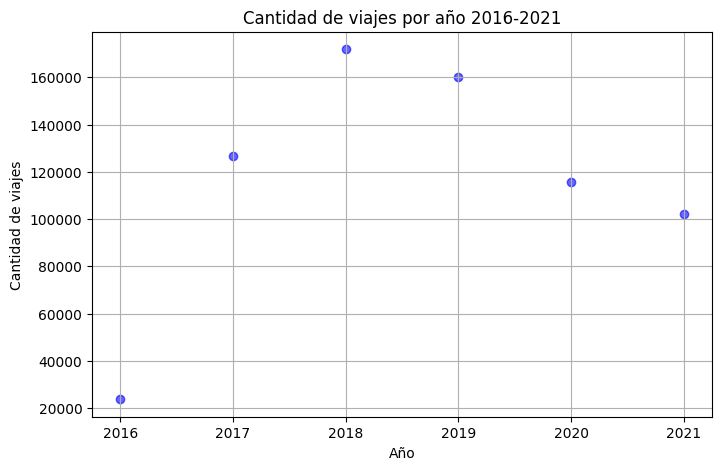

In [22]:
import matplotlib.pyplot as plt

df['year'] = df['start_time'].dt.year

viajes_por_año = df['year'].value_counts().sort_index()

años_unicos = viajes_por_año.index
print("Años que comprende el dataset:", list(años_unicos))


plt.figure(figsize=(8, 5))
plt.scatter(años_unicos, viajes_por_año, color='b', alpha=0.6)

plt.xlabel("Año")
plt.ylabel("Cantidad de viajes")
plt.title("Cantidad de viajes por año 2016-2021")
plt.xticks(años_unicos)
plt.grid(True)


plt.show()


Desde 2019 empezo a haber una caida en la cantidad de viajes. Probablemente debido al COVID-19. Ya que como su mismo nombre lo indica, comenzó en 2019. Esto tiene  sentido porque el confinamiento obligó a todos a no exponerse en las calles inecesariamente, que es exactamente lo que es un paseo en bicicleta por la ciudad. Además son bicicletas compartidas, por lo que este negocio de las bicicletas compartidas recivió una caida significativa, ¿Pero cuán significativa fue? Vamos a tomar en cuenta el año 2018, el año prepandemia y el 2021 en donde en la gráfica se registra la caida más grave de cantidad de viajes.

In [23]:

viajes_2018 = df[df['start_time'].dt.year == 2018].shape[0]
viajes_2021 = df[df['start_time'].dt.year == 2021].shape[0]

print(f"Total de viajes en 2018: {viajes_2018}")
print(f"Total de viajes en 2021: {viajes_2021}")

disminucion_porcentaje = ((viajes_2018 - viajes_2021) / viajes_2018) * 100

print(f"Porcentaje de disminución de viajes en 2021 respecto a 2018: {disminucion_porcentaje:.2f}%")



Total de viajes en 2018: 171892
Total de viajes en 2021: 102261
Porcentaje de disminución de viajes en 2021 respecto a 2018: 40.51%


Sería interesante explorar datos más recientes para observar si la tendencia cambió. Lamentablemente el data set solo cubre hasta 2021. Vamos a ver qué más podemos averiguar viendo más de cerca los patrones de demanda en estos años.

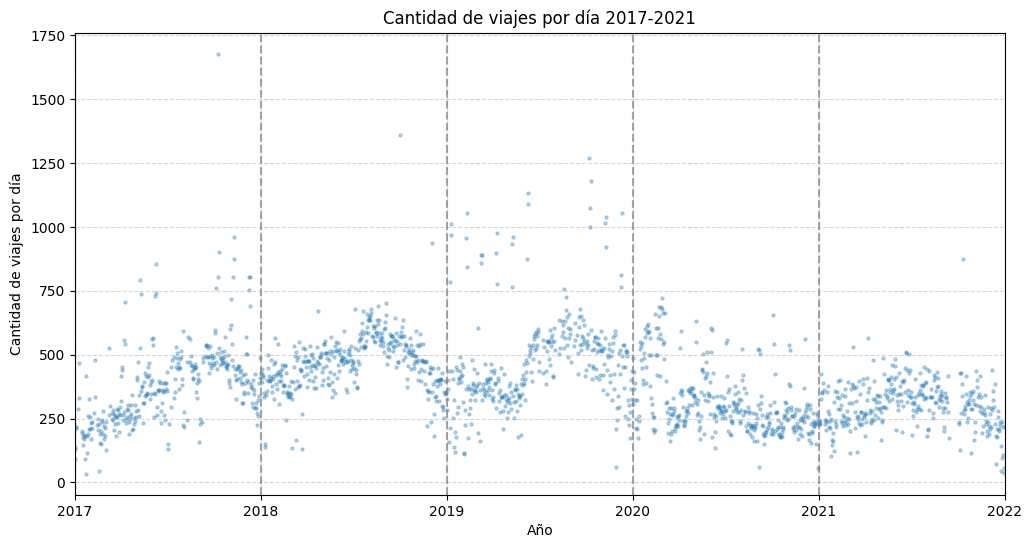

In [24]:

df['year'] = df['start_time'].dt.year
df['day_of_year'] = df['start_time'].dt.dayofyear

daily_trips = df.groupby(['year', 'day_of_year']).size().reset_index(name='trip_count')

daily_trips['year_float'] = daily_trips['year'] + (daily_trips['day_of_year'] / 365)

plt.figure(figsize=(12, 6))
plt.scatter(daily_trips['year_float'], daily_trips['trip_count'], alpha=0.3, s=5)
plt.xlabel('Año')
plt.ylabel('Cantidad de viajes por día')
plt.title('Cantidad de viajes por día 2017-2021')

plt.xlim(2017, daily_trips['year'].max() + 1)

for year in range(2017, daily_trips['year'].max() + 1):
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.7)


plt.grid(True, linestyle='--', alpha=0.5)

plt.show()




Se puede observar que al inicio de cada año la cantidad de viajes es baja, es ahí cuando se presenta el mínimo de viajes en todo el año. Pero se va recuperando al pasar de los meses hasta que se llega a la ultima cuarta parte del año, que es donde la tendencia alcista se vuelve bajista. Este ciclo completo se vuelve a repetir el proximo año, en donde nuevamente se inicia con el registro de menos viajes en el año. Esta tendencia es cierta hasta el año 2019, porque en 2020 parece que la tendencia es bajista todo el año, luego, hay una recuperacion en 2021 en donde se se nota aproximadamente el  mismo patrón que en los años anteriores. Vamos a ver cuándo ocurrió el primer caso registrado de COVID-19 en EEUU, y ver si la tendencia ciclica que se presenta en todos los años se rompe justamente cuando ocurre este primer caso de COVID-19.

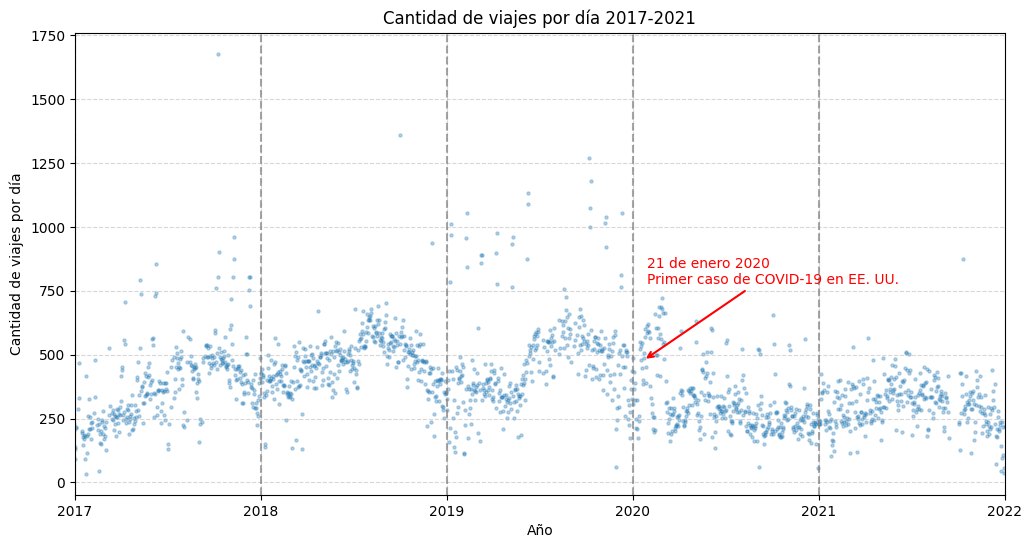

In [25]:

df['year'] = df['start_time'].dt.year
df['day_of_year'] = df['start_time'].dt.dayofyear


daily_trips = df.groupby(['year', 'day_of_year']).size().reset_index(name='trip_count')

daily_trips['year_float'] = daily_trips['year'] + (daily_trips['day_of_year'] / 365)

plt.figure(figsize=(12, 6))
plt.scatter(daily_trips['year_float'], daily_trips['trip_count'], alpha=0.3, s=5)
plt.xlabel('Año')
plt.ylabel('Cantidad de viajes por día')
plt.title('Cantidad de viajes por día 2017-2021')

plt.xlim(2017, daily_trips['year'].max() + 1)

for year in range(2017, daily_trips['year'].max() + 1):
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.7)


plt.grid(True, linestyle='--', alpha=0.5)

first_case_date = 2020 + (21 / 365)


plt.annotate('21 de enero 2020\nPrimer caso de COVID-19 en EE. UU.',
             xy=(first_case_date, daily_trips['trip_count'].max() - 1200),
             xytext=(first_case_date + 0.02, daily_trips['trip_count'].max() - 900),
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5),
             fontsize=10, color='red')

plt.show()


Pareciera que las conjeturas se apoyan en los datos. Ya que la tendencia solo es bajista en todo 2020 después del primer caso de COVID-19. En este año el ciclo de demanda se rompe. Aún así podría ser una casua multifactorial.
Exploremos como se comporta la demanda según la temporada del año para poder intentar entender el por qué del comportamiento cíclico de la demanda anual.

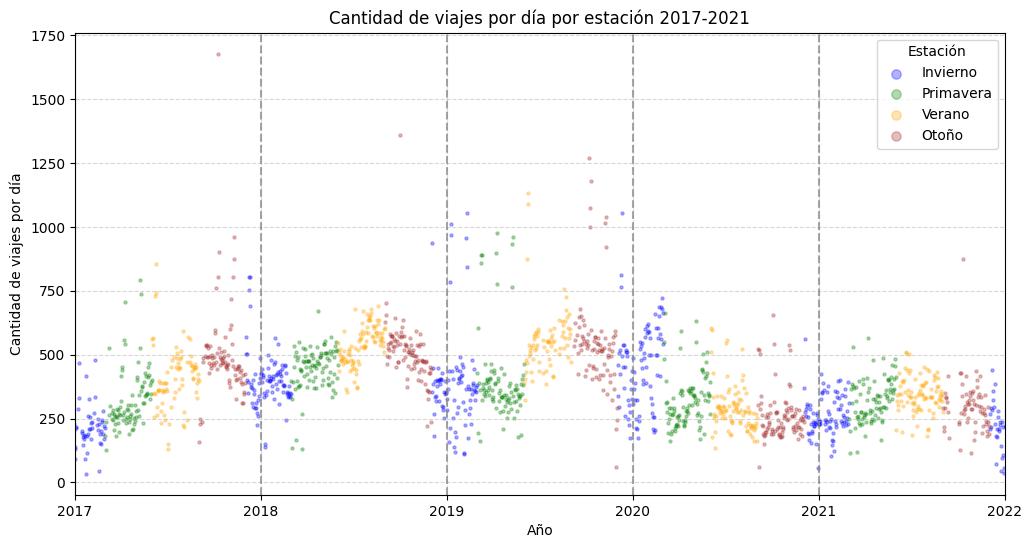

In [26]:
import numpy as np

def assign_season(date):
    if date.month in [12, 1, 2]:
        return 'Invierno'
    elif date.month in [3, 4, 5]:
        return 'Primavera'
    elif date.month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

df['season'] = df['start_time'].apply(assign_season)

df['year'] = df['start_time'].dt.year
df['day_of_year'] = df['start_time'].dt.dayofyear

daily_trips = df.groupby(['year', 'day_of_year', 'season']).size().reset_index(name='trip_count')

daily_trips['year_float'] = daily_trips['year'] + (daily_trips['day_of_year'] / 365)


plt.figure(figsize=(12, 6))
colors = {'Invierno': 'blue', 'Primavera': 'green', 'Verano': 'orange', 'Otoño': 'brown'}

for season, color in colors.items():
    season_data = daily_trips[daily_trips['season'] == season]
    plt.scatter(season_data['year_float'], season_data['trip_count'], alpha=0.3, s=5, label=season, color=color)

plt.xlabel('Año')
plt.ylabel('Cantidad de viajes por día')
plt.title('Cantidad de viajes por día por estación 2017-2021')
plt.xlim(2017, daily_trips['year'].max() + 1)

for year in range(2017, daily_trips['year'].max() + 1):
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.7)

plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(title='Estación', markerscale=3)

plt.show()


Este comportamiento sugiere una estacionalidad en los viajes en bicicleta compartida. Los datos parecen reflejar que la demanda parece seguir un patrón anual con tres fases:

- Inicio de Año (poca demanda): Durante las primeras semanas del año la demanda es baja. Esto puede estar relacionado con el clima más frío.

- Crecimiento en la Demanda (demanda creciente): A medida que avanza el año, especialmente cuando el clima mejora (primavera-verano), más personas parecen recurrir a tomar viajes en bicicleta, lo que genera la tendencia alcista. Esto también podría explicarse con la mejora de la movilidad urbana o campañas de marketing de las empresas de bicicletas compartidas.

- Declive (Aun aumento de la Demanda pero no sostenible): en la ultima parte del año, la demanda comienza a decaer. Esto podría estar influenciado por las vacaciones de verano (esto no es concluyente, pero definitivamente en otoño ocurre la mayor caida en cada ciclo).


Este patrón puede ser muy valioso para predecir la demanda futura, ya que sugiere que las empresas de bicicletas compartidas podrían optimizar la disponibilidad de bicicletas según las estaciones, incrementando la flota cuando la demanda es más alta y reduciéndola cuando la demanda disminuye. Además, podrían aprovechar los datos de años anteriores para preparar campañas de marketing en momentos clave del año debido a que la demanda parece bastante predecible en función de las estaciones del año.

Voy a continuar con algunas visualizciones que podrían dar más claridad sobre la demanda.

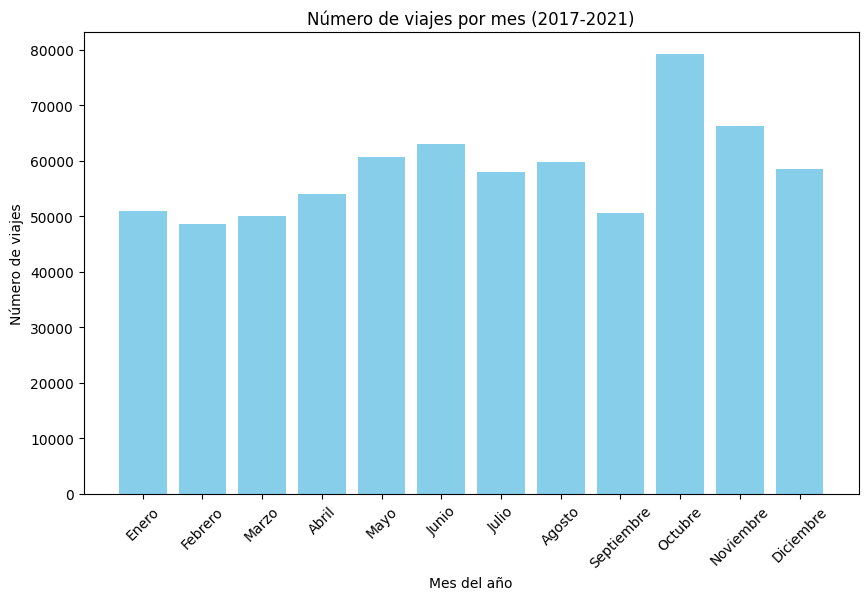

In [27]:
df['month'] = df['start_time'].dt.month

trips_by_month = df.groupby('month').size()

month_names = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

plt.figure(figsize=(10, 6))
plt.bar(trips_by_month.index, trips_by_month.values, color='skyblue')
plt.xlabel('Mes del año')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por mes (2017-2021)')

plt.xticks(trips_by_month.index, [month_names[i] for i in trips_by_month.index], rotation=45)

plt.show()


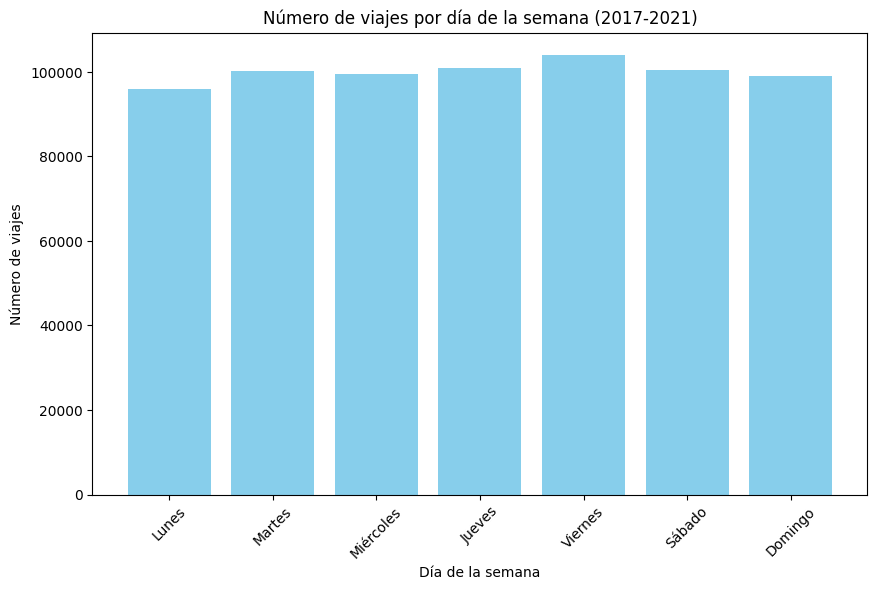

In [28]:
df['day_of_week'] = df['start_time'].dt.dayofweek

trips_by_day = df.groupby('day_of_week').size()

day_names = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}

plt.figure(figsize=(10, 6))
plt.bar(trips_by_day.index, trips_by_day.values, color='skyblue')
plt.xlabel('Día de la semana')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por día de la semana (2017-2021)')

plt.xticks(trips_by_day.index, [day_names[i] for i in trips_by_day.index], rotation=45)

plt.show()


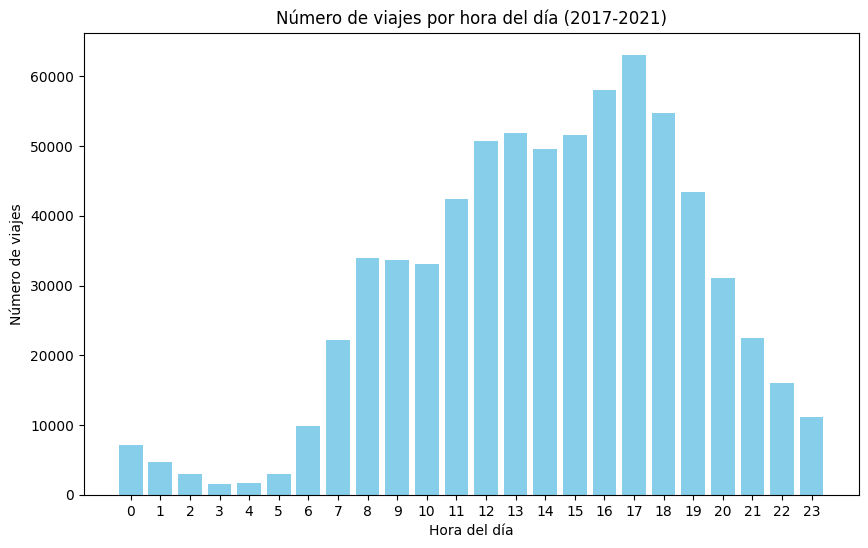

In [29]:
df['hour'] = df['start_time'].dt.hour

trips_by_hour = df.groupby('hour').size()

plt.figure(figsize=(10, 6))
plt.bar(trips_by_hour.index, trips_by_hour.values, color='skyblue')
plt.xlabel('Hora del día')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por hora del día (2017-2021)')
plt.xticks(trips_by_hour.index, rotation=0)
plt.show()


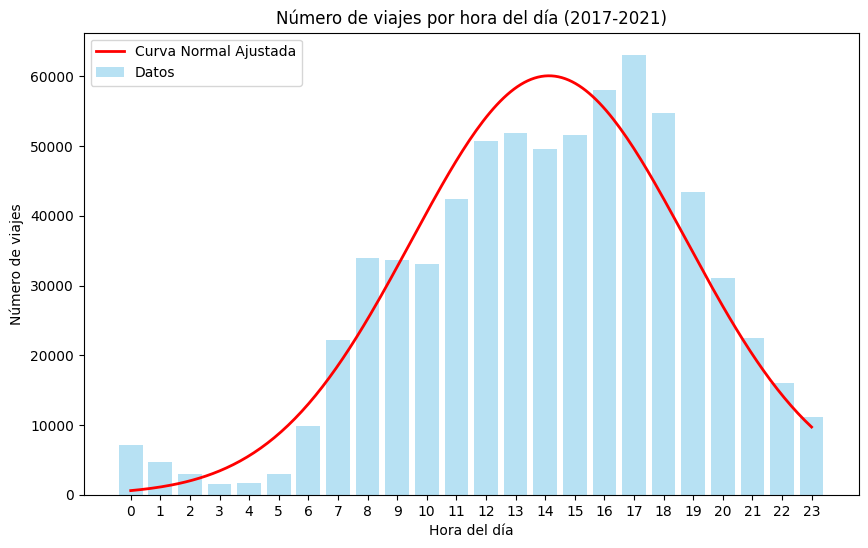

In [30]:
df['hour'] = df['start_time'].dt.hour

trips_by_hour = df.groupby('hour').size()

mean_val = np.average(trips_by_hour.index, weights=trips_by_hour.values)
std_val = np.sqrt(np.average((trips_by_hour.index - mean_val)**2, weights=trips_by_hour.values))

x = np.linspace(0, 23, 200)

pdf = (1 / (std_val * np.sqrt(2 * np.pi))) * np.exp( - ((x - mean_val)**2) / (2 * std_val**2) )

pdf_scaled = pdf * trips_by_hour.sum()

plt.figure(figsize=(10, 6))
plt.bar(trips_by_hour.index, trips_by_hour.values, color='skyblue', alpha=0.6, label="Datos")
plt.plot(x, pdf_scaled, 'r-', lw=2, label="Curva Normal Ajustada")
plt.xlabel('Hora del día')
plt.ylabel('Número de viajes')
plt.title('Número de viajes por hora del día (2017-2021)')
plt.xticks(trips_by_hour.index, rotation=0)
plt.legend()
plt.show()



- **Cálculo de la PDF normal:**  

  La fórmula de la densidad de probabilidad normal es  
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$
donde:
- $\mu$ es la media,
- $\sigma$ es la desviación estándar.

- **Escalado:**  
  Multiplicamos por el total de viajes y el ancho del bin (1 hora) para que la curva se aproxime a los conteos del histograma.


In [31]:
average_duration = df['duration'].mean()

print(f"La duración promedio de los viajes es: {average_duration:.2f} horas")


La duración promedio de los viajes es: 0.62 horas


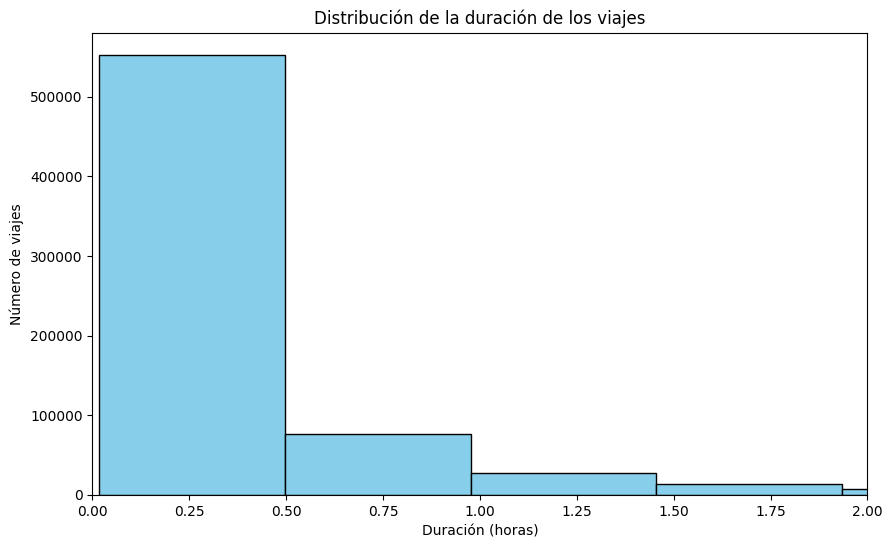

In [32]:
plt.figure(figsize=(10, 6))

plt.hist(df['duration'], bins=50, color='skyblue', edgecolor='black')

plt.title('Distribución de la duración de los viajes')
plt.xlabel('Duración (horas)')
plt.ylabel('Número de viajes')

plt.xlim(0, 2)

plt.show()


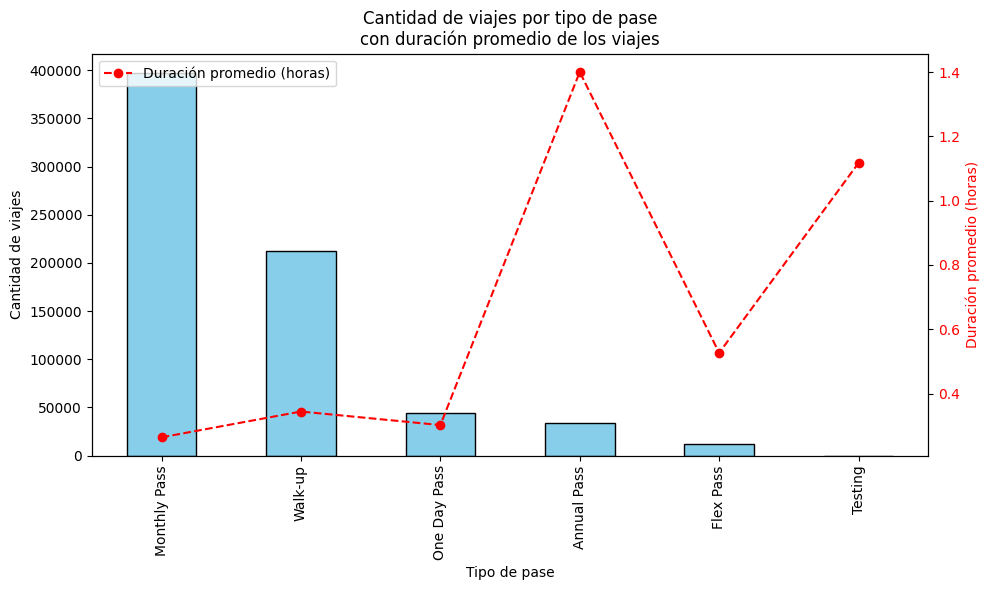

In [33]:
passholder_counts = df['passholder_type'].value_counts()

average_duration_by_passholder = df.groupby('passholder_type')['duration'].mean()

fig, ax1 = plt.subplots(figsize=(10, 6))

passholder_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax1)

ax1.set_title('Cantidad de viajes por tipo de pase\ncon duración promedio de los viajes')
ax1.set_xlabel('Tipo de pase')
ax1.set_ylabel('Cantidad de viajes')

ax2 = ax1.twinx()
ax2.plot(average_duration_by_passholder.index, average_duration_by_passholder.values,
         color='red', marker='o', label='Duración promedio (horas)', linestyle='--')

ax2.set_ylabel('Duración promedio (horas)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.xticks(rotation=45)
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


Esto puede ser un problema. Son datos desbalanceados porque hay alta representatividad de tipos de pase monthly pass y Walk-up, pero casi no hay de Flex pass o Testing.

Ahora vamos a ver la demanda por estaciones de bicicletas.

In [34]:
start_stations_count = df['start_station'].nunique()

end_stations_count = df['end_station'].nunique()

print(f"Estaciones de inicio únicas: {start_stations_count}")
print(f"Estaciones de fin únicas: {end_stations_count}")


Estaciones de inicio únicas: 364
Estaciones de fin únicas: 369


Existen demasiadas estaciones de bici como para analizarlas graficamente. Es una lástima que tenga poco tiempo para hacer este ejercicio, ya que se me ocurre que ya que tengo las coordenadas de los puntos de inicio y llegada, podría generar un cluster de varias estaciones tomando como referencia algun valor de distancia razonable. Experimentar para encontrar la mejor distribución de clusters y apartir de ahí hacer el análisis geoespacial!! Pero tengo poco tiempo para ello, no me quiero arriezgar a hacerlo, quedarme a la mitad del intento y no temrinar la prueba. Pero realmente sería interesante proceder así.

In [35]:
demand_by_start_station = df.groupby('start_station').size()

demand_by_end_station = df.groupby('end_station').size()


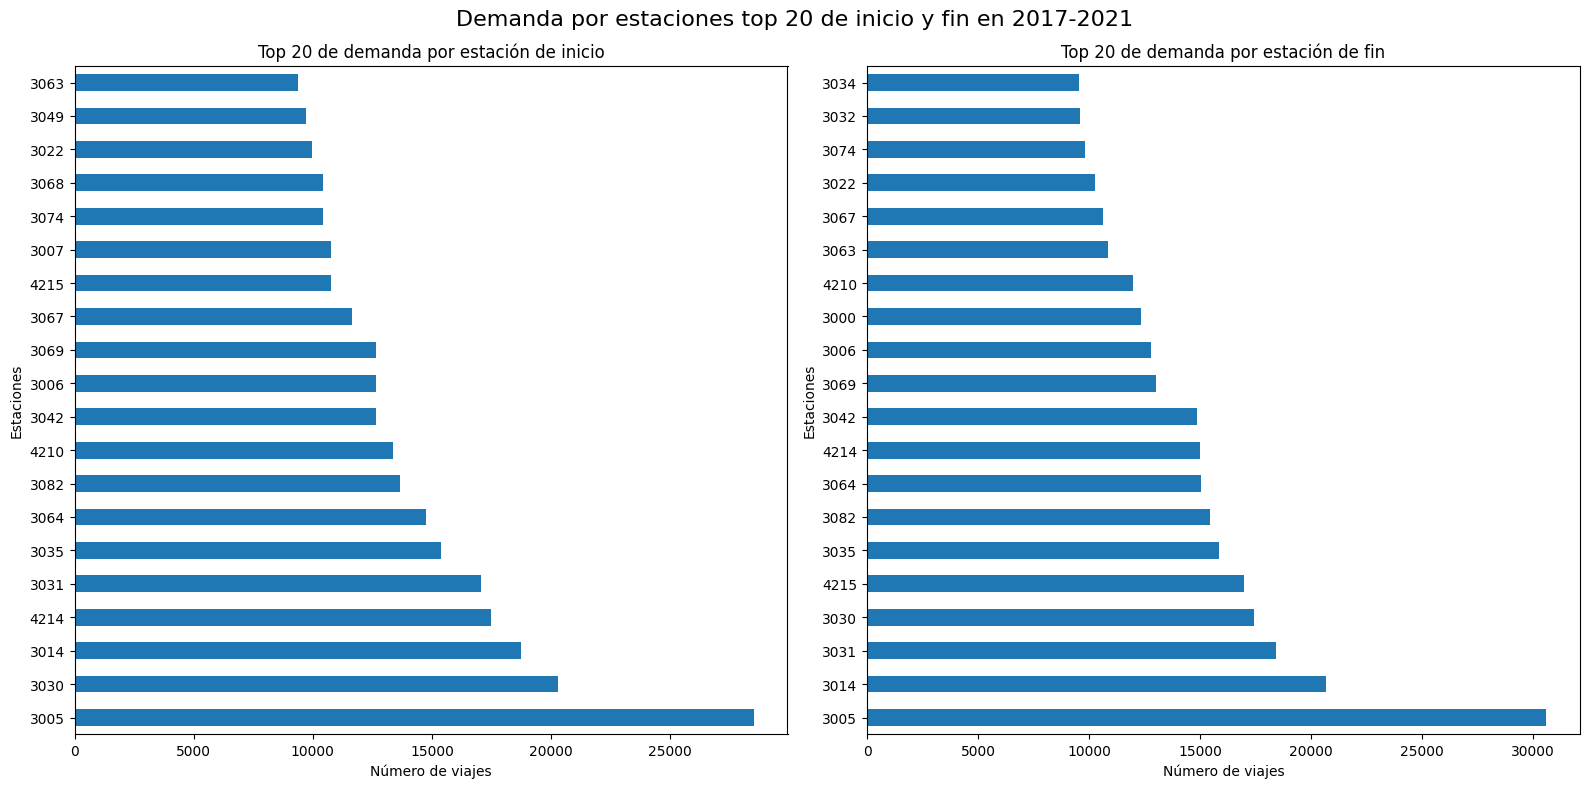

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

top_start_stations = demand_by_start_station.sort_values(ascending=False).head(20)
top_start_stations.plot(kind='barh', ax=ax1)
ax1.set_title("Top 20 de demanda por estación de inicio")
ax1.set_xlabel("Número de viajes")
ax1.set_ylabel("Estaciones")

top_end_stations = demand_by_end_station.sort_values(ascending=False).head(20)
top_end_stations.plot(kind='barh', ax=ax2)
ax2.set_title("Top 20 de demanda por estación de fin")
ax2.set_xlabel("Número de viajes")
ax2.set_ylabel("Estaciones")

plt.suptitle("Demanda por estaciones top 20 de inicio y fin en 2017-2021", fontsize=16)

plt.tight_layout()
plt.show()



Este es el top 20 de estaciones mas utilizadas. Definitivamente hay  mas demanda en la estación 3005. Pero veamos cuáles más estaciones tienen en común ambos grupos (end_station_start_estation)

Se pide analizar el crecimiento del tipo de pase Annual Pass. Asi que procederé con ello.

In [37]:

print(df['passholder_type'].unique())


['Walk-up' 'Monthly Pass' 'One Day Pass' 'Annual Pass' 'Flex Pass'
 'Testing']


year
2018     1188
2019    12002
2020    11151
2021     9751
dtype: int64


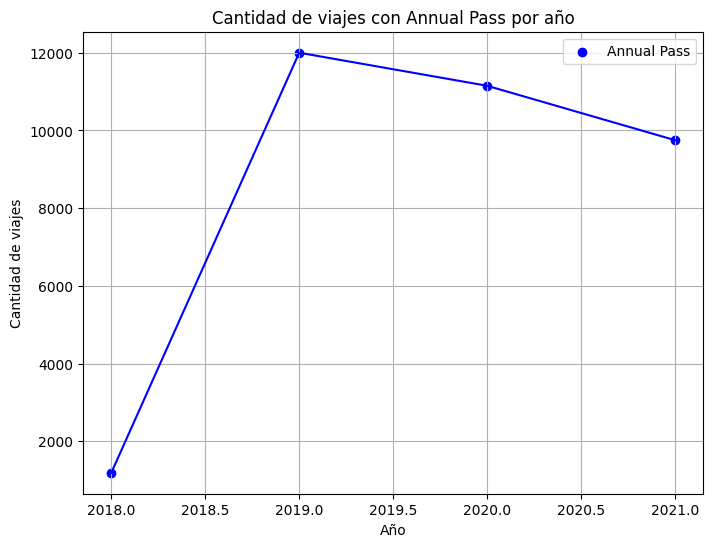

In [38]:
annual_pass_df = df[df['passholder_type'] == 'Annual Pass']

travel_count_by_year = annual_pass_df.groupby('year').size()

print(travel_count_by_year)

plt.figure(figsize=(8, 6))
plt.scatter(travel_count_by_year.index, travel_count_by_year.values, color='blue', label='Annual Pass')
plt.plot(travel_count_by_year.index, travel_count_by_year.values, color='blue')

plt.title('Cantidad de viajes con Annual Pass por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de viajes')

plt.legend()

plt.grid(True)
plt.show()

No parece que tenga una tendencia creciente en demanda en los últimos años, pero definitivamente lo tuvo de 2018 a 2019.

Vamos a comparar el comportamiento de la demanda para cada tipo de pase a lo largo de los años.

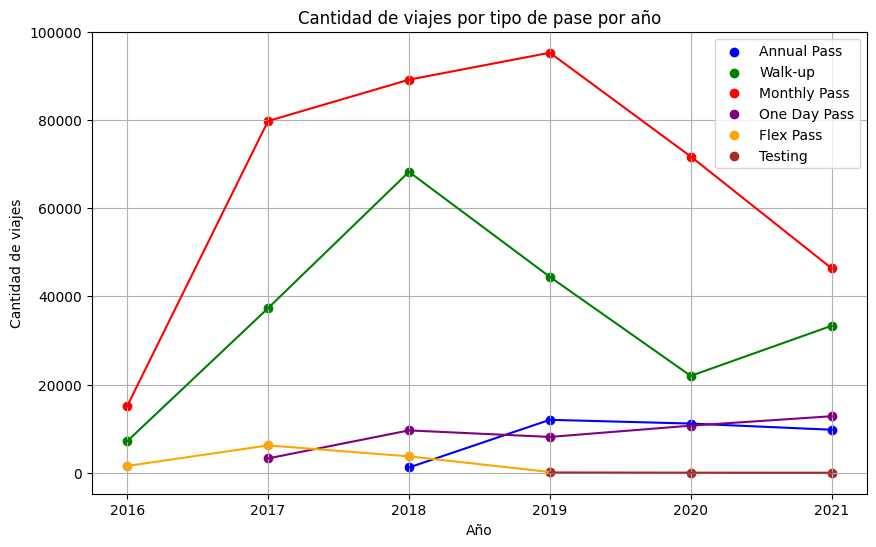

In [39]:

pass_types = ['Annual Pass', 'Walk-up', 'Monthly Pass', 'One Day Pass', 'Flex Pass', 'Testing']


plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for pass_type, color in zip(pass_types, colors):
    pass_df = df[df['passholder_type'] == pass_type]
    travel_count_by_year = pass_df.groupby('year').size()

    plt.scatter(travel_count_by_year.index, travel_count_by_year.values, color=color, label=pass_type)
    plt.plot(travel_count_by_year.index, travel_count_by_year.values, color=color)

plt.title('Cantidad de viajes por tipo de pase por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de viajes')

plt.legend()

plt.grid(True)
plt.show()

Podemos ver que el único tipo de pase con tendencia significativamente creciente del 2020 al 2021 fue el "Walk-Up". Vamos a ver más de cerca ese período:

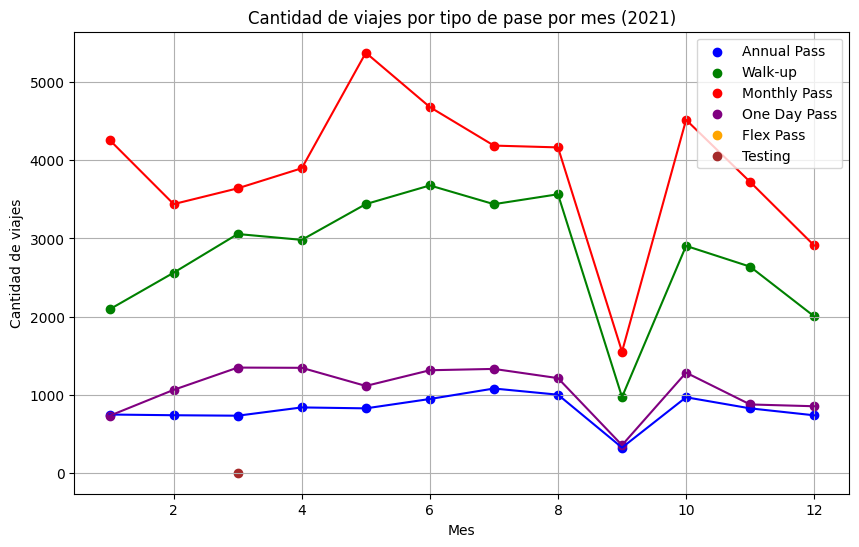

In [40]:

# Lista de tipos de pases
pass_types = ['Annual Pass', 'Walk-up', 'Monthly Pass', 'One Day Pass', 'Flex Pass', 'Testing']

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Colores para los diferentes tipos de pase
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

# Filtrar los datos para el año 2021
df_2021 = df[df['year'] == 2021]

# Iterar sobre los tipos de pase y graficar cada uno
for pass_type, color in zip(pass_types, colors):
    pass_df = df_2021[df_2021['passholder_type'] == pass_type]
    travel_count_by_month = pass_df.groupby('month').size()

    # Graficar dispersión y línea para cada tipo de pase
    plt.scatter(travel_count_by_month.index, travel_count_by_month.values, color=color, label=pass_type)
    plt.plot(travel_count_by_month.index, travel_count_by_month.values, color=color)

# Añadir título y etiquetas
plt.title('Cantidad de viajes por tipo de pase por mes (2021)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de viajes')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()


### Observaciones:

En esta parte exploratoria podemos concluir que:

 - Como ya se demostró, es claro que varias estaciones tanto de inicio como de termino de viaje son significativamente más concurridas que otras. En estos puntos debería haber más oferta de bicicletas, y mover el exceso de ellas (si las hay) de los puntos que presentan menos demanda.

 - Hasta el 2019 la demanda del servicio de bicicletas compartidas iba en aumento, pero durante la pandemia decreció y en 2021 se estabilizó. No puedo concluir  con estos datos si realmente la demanda va en aumento. De hecho la cantidad de viajes de 2018 a 2021 tenia tendencia negativa (Como lo muestra el primer gráfico de este notebook). Para verdaderamente responder a esta cuestión es imperativo revisar datos mas recientes: 2022-2025.

 - Los pases que han demostrado un crecimiento visualmente más acelerado son Walk-up y Monthly Pass. Pero estos pases también están entre los pases cuyos viajes tienen menos duración. Monthly Pass es el que registra más viajes. Por lo que no sería mala idea proyectar un uso más alto de bicicletas para este tipo de pase.

# 2) Modelo analítico

- Se pide que se logre saber si es posible inferir el tipo de pase tomando en cuenta las demas variables de viaje.

#### I) problema:
El objetivo es predecir el tipo de pase passholder_type. Es un tipo de clasificacion  multiclase, porque hay varios tipos de pase. En la red de bicicletas compartidas de Los Ángeles, hay varios tipos de membresías que atraen a usuarios con distintas necesidades y expectativas. Entender cómo y por qué estos usuarios se alinean con estas categorías específicas es crucial para comprender su comportamiento y atraer nuevos usuarios, lo que finalmente contribuirá al crecimiento de la red.

#### II) Análisis de las variables disponibles (Feature Engineering)

¿que variables pueden aportar información útil para el modelo?

De la exploración de datos anterior sabemos que la columna de duration y plan_duration tienen outliers que pueden sesgar el entrenamiento del modelo.
Truncaré ambas columnas, duration a 2 horas.

In [41]:
df['duration'] = df['duration'].clip(upper=2)

Ahora hay que especificar los valores atipicos en plan_duration

In [42]:

percentiles = np.percentile(df['plan_duration'], [25, 50, 75, 90, 95, 99, 100])
percentiles


array([ 0.01666667,  0.5       ,  0.5       ,  0.5       ,  6.08333333,
        6.08333333, 16.65      ])

La mayoría de los valores están en 0.5 horas. Pero hay valores extremos de hasta 16.65. Por lo que un buen punto de corte podría ser 6.08 horas que corresponde al percentil 95-99.

In [43]:
df['plan_duration'] = df['plan_duration'].clip(upper=6.08)

Ahora hay que elegir las variables con las que se entrenará el modelo. Si se eligen variables categóricas para entrenar el modelo utlilizaré One-Hot Encoding en ellas.

Mi primera propuesta como variables predictoras son las siguientes:

- duration.  Mide el tiempo del viaje, lo cual es clave para entender el tipo de usuario. | Numerica

- plan_duration.  Representa la duración del pase adquirido, influye en el tipo de suscripción. | Numerica

- start_lat, start_lon.  Ubicación de inicio, útil para ver patrones geográficos de uso.   | Numerica

- end_lat, end_lon.	Ubicación de destino, puede relacionarse con tipos de suscriptores frecuentes.  | Numerica

- hour.	La hora del viaje puede indicar patrones de uso (trabajo, ocio, etc.).    | Numerica

- day_of_week. 	Influye en el tipo de usuario, por ejemplo, laboral vs. recreativo.  | Categórica

- season. 	La estacionalidad puede afectar la cantidad de viajes y el tipo de usuario. | Categórica

- trip_route_category.  (ruta del viaje, puede ser relevante para el tipo de usuario).   | Categórica

El paso siguiente es crear un nuevo df con estas variables.


In [44]:
df_selected = df[['duration', 'plan_duration', 'start_lat', 'start_lon',
                  'end_lat', 'end_lon', 'hour', 'day_of_week', 'season', 'trip_route_category']].copy()


Ahora hay que pasar por One-Hot-Encoding las variables categóricas. Esta estrategia puede funcionar bien con modelos como: Random Forest o XGBoost.

In [45]:
df_selected = pd.get_dummies(df_selected, columns=['season', 'day_of_week', 'trip_route_category'], drop_first=True)


drop_first elimina la primer variable de cada columna transformada en dummy:

![image.png](attachment:image.png)

In [46]:
df_selected

,duration,plan_duration,start_lat,start_lon,end_lat,end_lon,hour,season_Otoño,season_Primavera,season_Verano,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,trip_route_category_Round Trip
0,0.583333,0.016667,33.748920,-118.275192,33.748920,-118.275192,11,False,False,True,True,False,False,False,False,False,True
1,0.533333,0.000000,34.035679,-118.270813,34.047749,-118.243172,17,True,False,False,False,False,False,False,False,True,False
2,0.100000,0.500000,34.046070,-118.233093,34.047749,-118.243172,9,False,True,False,False,False,False,False,False,False,False
3,2.000000,0.016667,34.062580,-118.290092,34.059689,-118.294662,11,True,False,False,False,False,False,False,False,True,False
4,0.233333,0.500000,34.026291,-118.277687,34.021660,-118.278687,17,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699995,0.283333,0.500000,34.049889,-118.255882,34.074829,-118.258728,18,False,True,False,False,True,False,False,False,False,False
699996,0.150000,0.500000,34.039188,-118.232529,34.056610,-118.237213,16,True,False,False,True,False,False,False,False,False,False
699997,0.100000,6.080000,34.049889,-118.255882,34.050480,-118.254593,15,False,False,False,False,False,False,False,True,False,False
699998,0.050000,0.016667,34.045181,-118.250237,34.045540,-118.256668,14,False,False,False,False,False,False,False,False,False,False


Ahora tengo 17 columnas, pero para modelos como random forest y XGBoost esto es aceptable. Muchas columnas pueden llevar a sobre ajuste si es que algunas columnas no aportan información útil. Pero en este caso, todas parecen relevantes. De cualquier manera esto lo podremos constatar con las métricas que se evaluará el rendimiento del modelo.

Vamosa hacer el diseño de train-test split

In [47]:
df_selected['passholder_type'] = df['passholder_type']

In [48]:
from sklearn.model_selection import train_test_split

X = df_selected.drop(columns=['passholder_type'])
y = df_selected['passholder_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")


Tamaño del conjunto de entrenamiento: (560000, 17)
Tamaño del conjunto de prueba: (140000, 17)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.9300

Reporte de clasificación:
              precision    recall  f1-score   support

 Annual Pass       0.80      0.93      0.86      6918
   Flex Pass       0.74      0.57      0.64      2337
Monthly Pass       1.00      1.00      1.00     79661
One Day Pass       0.68      0.38      0.49      8899
     Testing       0.50      0.19      0.28        21
     Walk-up       0.87      0.94      0.90     42164

    accuracy                           0.93    140000
   macro avg       0.77      0.67      0.69    140000
weighted avg       0.92      0.93      0.92    140000



Parece que en general es buen desempeño con precisión del 91%, pero hay clases con poco desempeño como one day pass y testing. Probablemente debido a que no hay suficiente representatividad de este tipo de pases en el data set, como ya se habia señalado antes en la fase de exploración de datos.

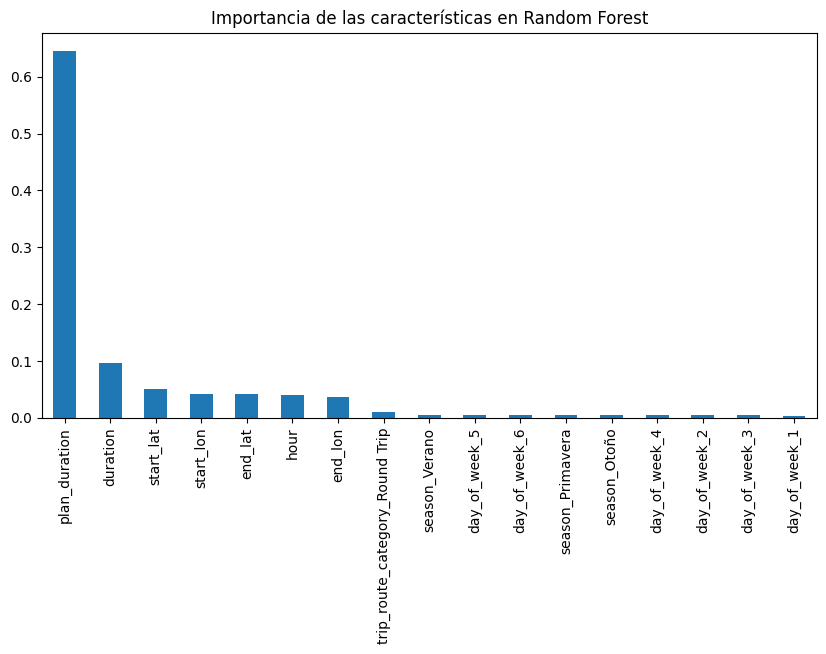

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importancia de las características en Random Forest")
plt.show()


Significa que el modelo clasifica correctamente el tipo de pase en la gran mayoría de los casos.

Monthly Pass (1.00 de f1-score) → Se clasifica perfectamente, seguido de Walk-Up. Posiblemente porque tienen mucha más representación en los datos.
Flex Pass y One Day Pass tienen bajo recall → El modelo no detecta bien a estos grupos. Quizá porque hay pocos datos de estas clases o no están bien representados en las variables, como y a se habia sugerido desde la exploración de datos.
Testing tiene el peor desempeño (f1-score 0.28) → Tal vez porque hay muy pocos ejemplos o porque las características no sean adecuadas para diferenciarlo.

plan_duration es la más importante (0.6) → Es esperado, porque la duración del plan claramente influye en el tipo de pase.
duration también es importante → Los viajes largos o cortos pueden influir en qué tipo de pase se usa.
Las coordenadas (start_lat, start_lon) tienen menos peso → Es posible que la ubicación no tenga tanta relevancia en la clasificación, o simplemente es que se debe hacer un analisis con un enfoque geoespacial exhaustivo.

¿Cómo mejorar el modelo?
Manejar el desbalance de la representatividad de las clases en el dataset.
Se podrian implementar tecnicas como oversampling o undersampling o reduciendo datos de la clase mayoritaria.

Explorar nuevas variables
Quizá hay características que faltan y que dejé fuera por falta de tiempo, pero que podrían ayudar a mejorar la precisión en las clases más débiles.
Tabién se podrían optimizar hiperparámetros. Como siempre, hay mucho margen de mejora en el desarrollo de los modelos, siempre se puede hacer algo mejor. Pero por ahora voy a tener que dejarlo aquí, ya que casi no me queda tiempo.


# 3) Evaluación del modelo.

Para la evaluación del modelo se realiza de manera automática a través de la
plataforma de kaggle en la siguiente liga:
https://www.kaggle.com/t/e82d8dd1223a4a459037106a2acab561

En el tab de Data aparecen tres archivos:

● train_set.csv: datos que servirán para construir el modelo

● test_set.csv: datos que no tienen la variable dependiente y que se debe hacer
predicción

● sample_submission.csv: formato en el cual se debe subir las predicciones

En el tab de Submit Predictions se hace upload de un archivo con el formato
adecuado. Favor de registrarse con algún pseudónimo que no esté relacionado
con su nombre y compártenoslo. El objetivo no es llegar al mejor resultado en
términos de la métrica de error, si no estar seguros de tomar en cuenta aspectos
indispensables al crear este modelo analítico. Por lo que sobrepasando el benchmark
se considera una buena entrega.


Mi modelo nunca utilizo la columna trip_id, pero para evaluar el modelo kaggle me lo pide.

ahora tengo que trabajar con el test_set.csv para poder pasarselo a mi modelo. básicamente tengo que pasarlo por el mismo tratamiento de datos para dejarlo identico.

Hay un terrible problema. Mi mejor variable predictora con la que entreno mi modelo es plan_duration, pero el test_set no cuenta con esta variable!! No debería faltar esa variable en el test_set, a mi parecer es una terrible práctica en el procedimiento de la evaluación del modelo. Ya que debió haberse quitado desde el train_set si es que no se iba a tomar en cuenta para poder evaluar el modelo con ella. Lo que habria oblicado a desarrollar otro enfoque para la creación del modelo (como uno geoespacial), no que ya gasté todo el tiempo en este enfoque y no me queda tiempo para encontrar una mejor variable predictora.

In [51]:
test_set = pd.read_csv('test_set.csv')

<ipython-input-51-09d2068d1b79>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_set = pd.read_csv('test_set.csv')


In [52]:
test_set.isna().sum()

,0
trip_id,0
duration,0
start_time,0
end_time,0
start_lat,4622
start_lon,4622
end_lat,14891
end_lon,14891
bike_id,0
trip_route_category,0


In [53]:
median_plan_duration = df['plan_duration'].median()

if 'plan_duration' not in test_set.columns:
    test_set['plan_duration'] = median_plan_duration

test_set['start_lat'] = test_set['start_lat'].fillna(test_set['start_lat'].mean())
test_set['start_lon'] = test_set['start_lon'].fillna(test_set['start_lon'].mean())
test_set['end_lat'] = test_set['end_lat'].fillna(test_set['end_lat'].mean())
test_set['end_lon'] = test_set['end_lon'].fillna(test_set['end_lon'].mean())


In [54]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569885 entries, 0 to 569884
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              569885 non-null  int64  
 1   duration             569885 non-null  int64  
 2   start_time           569885 non-null  object 
 3   end_time             569885 non-null  object 
 4   start_lat            569885 non-null  float64
 5   start_lon            569885 non-null  float64
 6   end_lat              569885 non-null  float64
 7   end_lon              569885 non-null  float64
 8   bike_id              569885 non-null  object 
 9   trip_route_category  569885 non-null  object 
 10  start_station        569885 non-null  int64  
 11  end_station          569885 non-null  int64  
 12  plan_duration        569885 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 56.5+ MB


In [55]:
test_set

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,plan_duration
0,17059130,12,1/1/2017 0:24,1/1/2017 0:36,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028,0.5
1,17059129,17,1/1/2017 0:28,1/1/2017 0:45,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018,0.5
2,17059126,20,1/1/2017 0:39,1/1/2017 0:59,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055,0.5
3,17059125,12,1/1/2017 0:43,1/1/2017 0:55,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079,0.5
4,17061379,48,1/1/2017 0:56,1/1/2017 1:44,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569880,179407876,25,12/31/2021 23:03,12/31/2021 23:28,34.045849,-118.254402,34.040989,-118.255798,14027,One Way,4516,3033,0.5
569881,179408277,19,12/31/2021 23:29,12/31/2021 23:48,34.040989,-118.255798,34.041130,-118.267982,14027,One Way,3033,3011,0.5
569882,179408276,8,12/31/2021 23:40,12/31/2021 23:48,34.044701,-118.252441,34.051941,-118.243530,20006,One Way,3031,3030,0.5
569883,179409877,43,12/31/2021 23:47,1/1/2022 0:30,34.044701,-118.252441,34.044701,-118.252441,16214,Round Trip,3031,3031,0.5


In [56]:
test_set_processed = test_set.copy()

test_set_processed = test_set_processed.drop(columns=['trip_id', 'bike_id', 'start_station', 'end_station'])

print(test_set_processed.columns)


Index(['duration', 'start_time', 'end_time', 'start_lat', 'start_lon',
       'end_lat', 'end_lon', 'trip_route_category', 'plan_duration'],
      dtype='object')


In [57]:
cols = list(test_set_processed.columns)

remaining = [col for col in cols if col not in ['duration', 'plan_duration']]
new_order = ['duration', 'plan_duration'] + remaining

test_set_processed = test_set_processed[new_order]

print(test_set_processed.columns)


Index(['duration', 'plan_duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'trip_route_category'],
      dtype='object')


In [58]:
test_set_processed['duration'] = test_set_processed['duration'] / 60
test_set_processed['plan_duration'] = test_set_processed['plan_duration'] / 60

In [59]:
test_set_processed['start_time'] = test_set_processed['start_time'].str.replace('-', '/', regex=False)
test_set_processed['end_time'] = test_set_processed['end_time'].str.replace('-', '/', regex=False)

In [60]:
import re

def has_seconds(time_str):
    pattern = r'\d{2}:\d{2}:\d{2}'
    return bool(re.search(pattern, time_str))

test_set_processed['has_seconds_start'] = test_set_processed['start_time'].astype(str).apply(has_seconds)

test_set_processed['has_seconds_end'] = test_set_processed['end_time'].astype(str).apply(has_seconds)

test_set_without_seconds_start = test_set_processed[~test_set_processed['has_seconds_start']]

test_set_without_seconds_end = test_set_processed[~test_set_processed['has_seconds_end']]

print("Registros de start_time sin segundos:")
print(test_set_without_seconds_start[['start_time', 'has_seconds_start']].head())

print("\nRegistros de end_time sin segundos:")
print(test_set_without_seconds_end[['end_time', 'has_seconds_end']].head())

test_set_processed.loc[~test_set_processed['has_seconds_start'], 'start_time'] = \
    test_set_processed.loc[~test_set_processed['has_seconds_start'], 'start_time'] + ':00'

test_set_processed.loc[~test_set_processed['has_seconds_end'], 'end_time'] = \
    test_set_processed.loc[~test_set_processed['has_seconds_end'], 'end_time'] + ':00'

print("\nDataFrame actualizado:")
print(test_set_processed[['start_time', 'has_seconds_start', 'end_time', 'has_seconds_end']].head())


Registros de start_time sin segundos:
      start_time  has_seconds_start
0  1/1/2017 0:24              False
1  1/1/2017 0:28              False
2  1/1/2017 0:39              False
3  1/1/2017 0:43              False
4  1/1/2017 0:56              False

Registros de end_time sin segundos:
        end_time  has_seconds_end
0  1/1/2017 0:36            False
1  1/1/2017 0:45            False
2  1/1/2017 0:59            False
3  1/1/2017 0:55            False
4  1/1/2017 1:44            False

DataFrame actualizado:
         start_time  has_seconds_start          end_time  has_seconds_end
0  1/1/2017 0:24:00              False  1/1/2017 0:36:00            False
1  1/1/2017 0:28:00              False  1/1/2017 0:45:00            False
2  1/1/2017 0:39:00              False  1/1/2017 0:59:00            False
3  1/1/2017 0:43:00              False  1/1/2017 0:55:00            False
4  1/1/2017 0:56:00              False  1/1/2017 1:44:00            False


In [61]:
def ajustar_fecha(fecha):
    partes = fecha.split(' ')
    fecha_parts = partes[0].split('/')
    if len(fecha_parts[0]) == 4:
        return fecha
    else:
        fecha_parts = [fecha_parts[2], fecha_parts[1], fecha_parts[0]]
        fecha_nueva = '/'.join(fecha_parts) + ' ' + partes[1]
        return fecha_nueva

test_set_processed['start_time'] = test_set_processed['start_time'].apply(ajustar_fecha)

test_set_processed['end_time'] = test_set_processed['end_time'].apply(ajustar_fecha)

print(test_set_processed[['start_time', 'end_time']].head())


         start_time          end_time
0  2017/1/1 0:24:00  2017/1/1 0:36:00
1  2017/1/1 0:28:00  2017/1/1 0:45:00
2  2017/1/1 0:39:00  2017/1/1 0:59:00
3  2017/1/1 0:43:00  2017/1/1 0:55:00
4  2017/1/1 0:56:00  2017/1/1 1:44:00


In [62]:
def fix_date_format(date_str):
    parts = date_str.split(' ')
    date_parts = parts[0].split('/')

    if int(date_parts[1]) > 12:
        date_parts[1], date_parts[2] = date_parts[2], date_parts[1]

    fixed_date = '/'.join(date_parts)

    return f"{fixed_date} {parts[1]}"

test_set_processed['start_time'] = test_set_processed['start_time'].apply(fix_date_format)

test_set_processed['end_time'] = test_set_processed['end_time'].apply(fix_date_format)

print(test_set_processed[['start_time', 'end_time']].head())


         start_time          end_time
0  2017/1/1 0:24:00  2017/1/1 0:36:00
1  2017/1/1 0:28:00  2017/1/1 0:45:00
2  2017/1/1 0:39:00  2017/1/1 0:59:00
3  2017/1/1 0:43:00  2017/1/1 0:55:00
4  2017/1/1 0:56:00  2017/1/1 1:44:00


In [63]:
test_set_processed['start_time'] = pd.to_datetime(test_set_processed['start_time'], format='%Y/%m/%d %H:%M:%S')

test_set_processed['end_time'] = pd.to_datetime(test_set_processed['end_time'], format='%Y/%m/%d %H:%M:%S')

print(test_set_processed[['start_time', 'end_time']].head())


           start_time            end_time
0 2017-01-01 00:24:00 2017-01-01 00:36:00
1 2017-01-01 00:28:00 2017-01-01 00:45:00
2 2017-01-01 00:39:00 2017-01-01 00:59:00
3 2017-01-01 00:43:00 2017-01-01 00:55:00
4 2017-01-01 00:56:00 2017-01-01 01:44:00


In [64]:
test_set_processed['duration'] = test_set_processed['duration'].clip(upper=2)

In [65]:
test_set_processed['plan_duration'] = test_set_processed['plan_duration'].clip(upper=6.08)

In [66]:
df_test = test_set_processed[['duration', 'plan_duration', 'start_lat', 'start_lon',
                              'end_lat', 'end_lon', 'trip_route_category']].copy()

df_test['hour'] = test_set_processed['start_time'].dt.hour

df_test['day_of_week'] = test_set_processed['start_time'].dt.dayofweek

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df_test['season'] = test_set_processed['start_time'].dt.month.apply(get_season)

df_test = df_test[['duration', 'plan_duration', 'start_lat', 'start_lon',
                   'end_lat', 'end_lon', 'hour', 'day_of_week', 'season', 'trip_route_category']]

df_test.head()


,duration,plan_duration,start_lat,start_lon,end_lat,end_lon,hour,day_of_week,season,trip_route_category
0,0.200000,0.008333,34.058319,-118.246094,34.058319,-118.246094,0,6,winter,Round Trip
1,0.283333,0.008333,34.049980,-118.247162,34.043732,-118.260139,0,6,winter,One Way
2,0.333333,0.008333,34.063389,-118.236160,34.044159,-118.251579,0,6,winter,One Way
3,0.200000,0.008333,34.048851,-118.246422,34.050140,-118.233238,0,6,winter,One Way
4,0.800000,0.008333,34.049198,-118.252831,34.049198,-118.252831,0,6,winter,Round Trip


In [67]:
df_test.head(200)

,duration,plan_duration,start_lat,start_lon,end_lat,end_lon,hour,day_of_week,season,trip_route_category
0,0.200000,0.008333,34.058319,-118.246094,34.058319,-118.246094,0,6,winter,Round Trip
1,0.283333,0.008333,34.049980,-118.247162,34.043732,-118.260139,0,6,winter,One Way
2,0.333333,0.008333,34.063389,-118.236160,34.044159,-118.251579,0,6,winter,One Way
3,0.200000,0.008333,34.048851,-118.246422,34.050140,-118.233238,0,6,winter,One Way
4,0.800000,0.008333,34.049198,-118.252831,34.049198,-118.252831,0,6,winter,Round Trip
...,...,...,...,...,...,...,...,...,...,...
195,0.016667,0.008333,34.049301,-118.238808,34.050911,-118.240967,15,2,winter,One Way
196,0.133333,0.008333,34.048851,-118.246422,34.049301,-118.238808,16,2,winter,One Way
197,0.183333,0.008333,34.044170,-118.261169,34.044701,-118.252441,16,2,winter,One Way
198,0.183333,0.008333,34.044170,-118.261169,34.044701,-118.252441,16,2,winter,One Way


In [68]:
season_mapping = {
    'winter': 'Invierno',
    'spring': 'Primavera',
    'summer': 'Verano',
    'fall': 'Otoño'
}

df_test['season'] = df_test['season'].map(season_mapping)

print(df_test['season'].unique())


['Invierno' 'Primavera' 'Verano' 'Otoño']


In [69]:
df_test = pd.get_dummies(df_test, columns=['season', 'day_of_week', 'trip_route_category'], drop_first=True)


In [70]:
df_test

,duration,plan_duration,start_lat,start_lon,end_lat,end_lon,hour,season_Otoño,season_Primavera,season_Verano,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,trip_route_category_Round Trip
0,0.200000,0.008333,34.058319,-118.246094,34.058319,-118.246094,0,False,False,False,False,False,False,False,False,True,True
1,0.283333,0.008333,34.049980,-118.247162,34.043732,-118.260139,0,False,False,False,False,False,False,False,False,True,False
2,0.333333,0.008333,34.063389,-118.236160,34.044159,-118.251579,0,False,False,False,False,False,False,False,False,True,False
3,0.200000,0.008333,34.048851,-118.246422,34.050140,-118.233238,0,False,False,False,False,False,False,False,False,True,False
4,0.800000,0.008333,34.049198,-118.252831,34.049198,-118.252831,0,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569880,0.416667,0.008333,34.045849,-118.254402,34.040989,-118.255798,23,False,False,False,False,False,False,True,False,False,False
569881,0.316667,0.008333,34.040989,-118.255798,34.041130,-118.267982,23,False,False,False,False,False,False,True,False,False,False
569882,0.133333,0.008333,34.044701,-118.252441,34.051941,-118.243530,23,False,False,False,False,False,False,True,False,False,False
569883,0.716667,0.008333,34.044701,-118.252441,34.044701,-118.252441,23,False,False,False,False,False,False,True,False,False,True


In [71]:
y_test_pred = rf_model.predict(df_test)

df_predictions = pd.DataFrame(y_test_pred, columns=['passholder_type'])

df_predictions['trip_id'] = test_set['trip_id'].values

print(df_predictions.head())

df_predictions.to_csv('predictions.csv', index=False)


  passholder_type   trip_id
0         Walk-up  17059130
1         Walk-up  17059129
2         Walk-up  17059126
3         Walk-up  17059125
4         Walk-up  17061379


In [72]:
df_predictions = df_predictions[['trip_id', 'passholder_type']]

df_predictions.to_csv('predictions.csv', index=False)


inspeccionando las predicciones, noto que son erroneas porque solo pertenecen a un solo tipo de dato, Walk-Up.

Es lamentable cuando una variable clave como plan_duration no está disponible en el conjunto de prueba y afecta el rendimiento del modelo. Los modelos de machine learning a menudo dependen de patrones específicos que aprenden de las características de entrada, y la falta de una variable que fue significativa durante el entrenamiento puede hacer que las predicciones sean sesgadas o no informativas.

sin la variable clave para poder predecir necesito un enfoque metodologico nuevo, nada predecia mejor como esa variable. Ahora lo que haria seria tomar un enfoque de más ingeniería de caracteristicas, y muy probablemente un analisis geoespacial. Pero ya no tengo tiempo, así que intentare entrenar de nuevo el modelo pero ahora sin la variable clave. Esto afectara gravemente el rendimiento, lo se de antemano.

Cross validation:


In [ ]:
X_train = X_train.drop(columns=['plan_duration'], errors='ignore')
X_test = X_test.drop(columns=['plan_duration'], errors='ignore')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [ ]:
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Precisión media de la validación cruzada: {cv_scores.mean():.4f}")
print(f"Desviación estándar de la precisión: {cv_scores.std():.4f}")


Precisión media de la validación cruzada: 0.7222
Desviación estándar de la precisión: 0.0010


En promedio el modelo tiene una precisión del 72.22% en los 5 folds de la validación cruzada. Es un rendimiento bastante decente, pero también hay margen para mejorar, pero por problemas de tiempo para la entrega de esta prueba no podré dedicarme al mejoramiento de las metricas, como me gustaría hacer.

La desviación estándar muy baja indica que el rendimiento del modelo es muy consistente en todos los folds de la validación cruzada. Esto es una buena señal porque significa que el modelo está generalizando bien y no está sesgado por un fold específico.

In [77]:
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.7266

Reporte de clasificación:
              precision    recall  f1-score   support

 Annual Pass       0.61      0.24      0.34      6918
   Flex Pass       0.42      0.11      0.17      2337
Monthly Pass       0.75      0.89      0.82     79661
One Day Pass       0.54      0.27      0.36      8899
     Testing       0.60      0.14      0.23        21
     Walk-up       0.69      0.63      0.66     42164

    accuracy                           0.73    140000
   macro avg       0.60      0.38      0.43    140000
weighted avg       0.71      0.73      0.71    140000



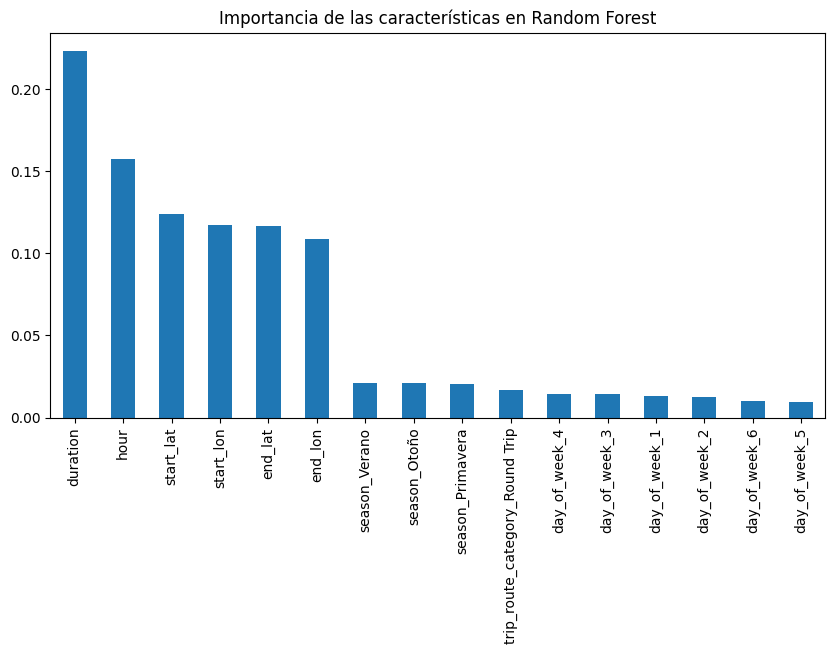

In [78]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importancia de las características en Random Forest")
plt.show()

Parece que sin plan_duration, el modelo aún mantiene un 72.66% de precisión, pero tiene dificultades para predecir ciertas clases, especialmente Annual Pass y Flex Pass, donde el recall es muy bajo.

Ahora de nuevo voy a producir las predicciones sobre el test_set.csv

In [79]:
df_test = df_test.drop(columns=['plan_duration'], errors='ignore')


In [80]:
y_test_pred = rf_model.predict(df_test)

df_predictions = pd.DataFrame(y_test_pred, columns=['passholder_type'])

df_predictions['trip_id'] = test_set['trip_id'].values

print(df_predictions.head())

df_predictions.to_csv('predictions.csv', index=False)

df_predictions = df_predictions[['trip_id', 'passholder_type']]

df_predictions.to_csv('predictions.csv', index=False)

  passholder_type   trip_id
0         Walk-up  17059130
1    Monthly Pass  17059129
2    Monthly Pass  17059126
3         Walk-up  17059125
4         Walk-up  17061379


Estas predicciones generadas son mejores que con el modelo anterior. Asi que este csv lo mandare a kaggle.

In [81]:
df_check = pd.read_csv("predictions.csv")
print(df_check.shape)


(569885, 2)


In [82]:
print(df_test.shape)


(569885, 16)


Kaggle no acepta mi archivo porque el data set de test viene con una fila de menos. Voy a agregar artificialmente esa fila.Ademas tambien falta una entrada de dato, la voy a tener que crear artificialmente tambien. Parece que a los organizadores del consurso se les fueron estos dos detalles.

Mi puntaje en kaggle fue el siguiente:

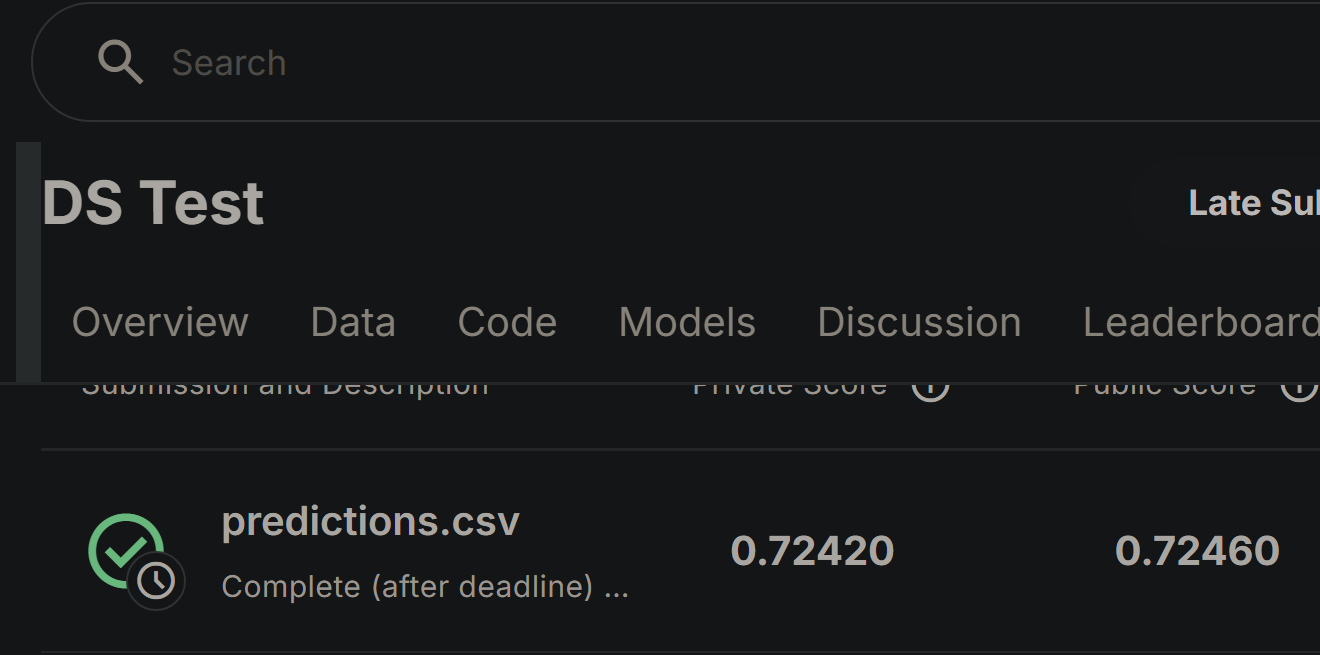

En el pdf de la prueba dice que sobrepasando el puntaje del benchmark es suficiente, pero no aparece por ningún lado cuál es el benchmark.